# Задача

Разработать алгоритм для поиска похожих товаров, оценить результат с помощью метрики accuracy@5.

## Данные

- `base.csv` - база с товарами и их признаками:
    - `Id` - идентификатор товара
    - `0..71` - различные параметры товаров
- `train.csv` - тренировочные данные:
    - `Id` - идентификатор запроса
    - `0..71` - различные параметры товаров
    - `Target` - идентификатор максимально похожего товара
- `validation.csv` - валидационные данные:
    - `Id` - идентификатор запроса
    - `0..71` - различные параметры товаров
- `validation_answer.csv` - правильные ответы к валидационному набору
    - `Id` - идентификатор запроса
    - `Expected` - идентификатор максимально похожего товара

# Подготовка окружения

Подключим необходимые библиотеки

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import faiss
from tqdm.notebook import tqdm
from warnings import filterwarnings
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler

Установим необходимые параметры

In [2]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', '{:.2f}'.format)

filterwarnings('ignore')

RANDOM_SEED = 0x1337

# Загрузка, анализ и предобработка данных

## Загрузка данных

Загрузим данные (товары с признаками, тренировочный и валидационный наборы)

In [3]:
df_base = pd.read_csv("base.csv")
df_train = pd.read_csv("train.csv")
df_valid = pd.read_csv("validation.csv")
df_answer = pd.read_csv("validation_answer.csv")

Выведем размерности данных

In [4]:
display(df_base.shape)
display(df_train.shape)
display(df_valid.shape)
display(df_answer.shape)

(2918139, 73)

(100000, 74)

(100000, 73)

(100000, 2)

Выведем первые 5 элементов

In [5]:
display(df_base.head(5).T)

,0,1,2,3,4
Id,0-base,1-base,2-base,3-base,4-base
0,-115.08,-34.56,-54.23,-87.52,-72.74
1,11.15,13.33,6.38,4.04,6.52
2,-64.43,-69.79,-29.21,-87.80,43.67
3,-118.88,-166.53,-133.41,-185.07,-140.61
...,...,...,...,...,...
67,-4.70,24.35,66.33,-20.57,-2.51
68,92.93,179.94,81.07,137.21,65.32
69,115.27,116.83,116.59,117.47,135.05
70,-112.76,-84.89,-1074.46,-1074.46,-1074.46


Переименуем столбцы и сделаем нумерацию численной

In [6]:
for df in [df_base, df_train, df_valid, df_answer]:
    df.columns = df.columns.str.lower()
    df.set_index('id', inplace=True)

Разделим тренировочную выборку на обучающую и валидационную

In [7]:
df_train_target = df_train['target']
df_train = df_train.drop(['target'], axis=1)

## Анализ и предобработка данных

Проверим данные на наличие дубликатов

In [8]:
display(df_base.duplicated().sum())

0

Проверим наличие пропусков

In [9]:
display(df_base.isna().sum().sum())

0

Построим гистограммы параметров товаров

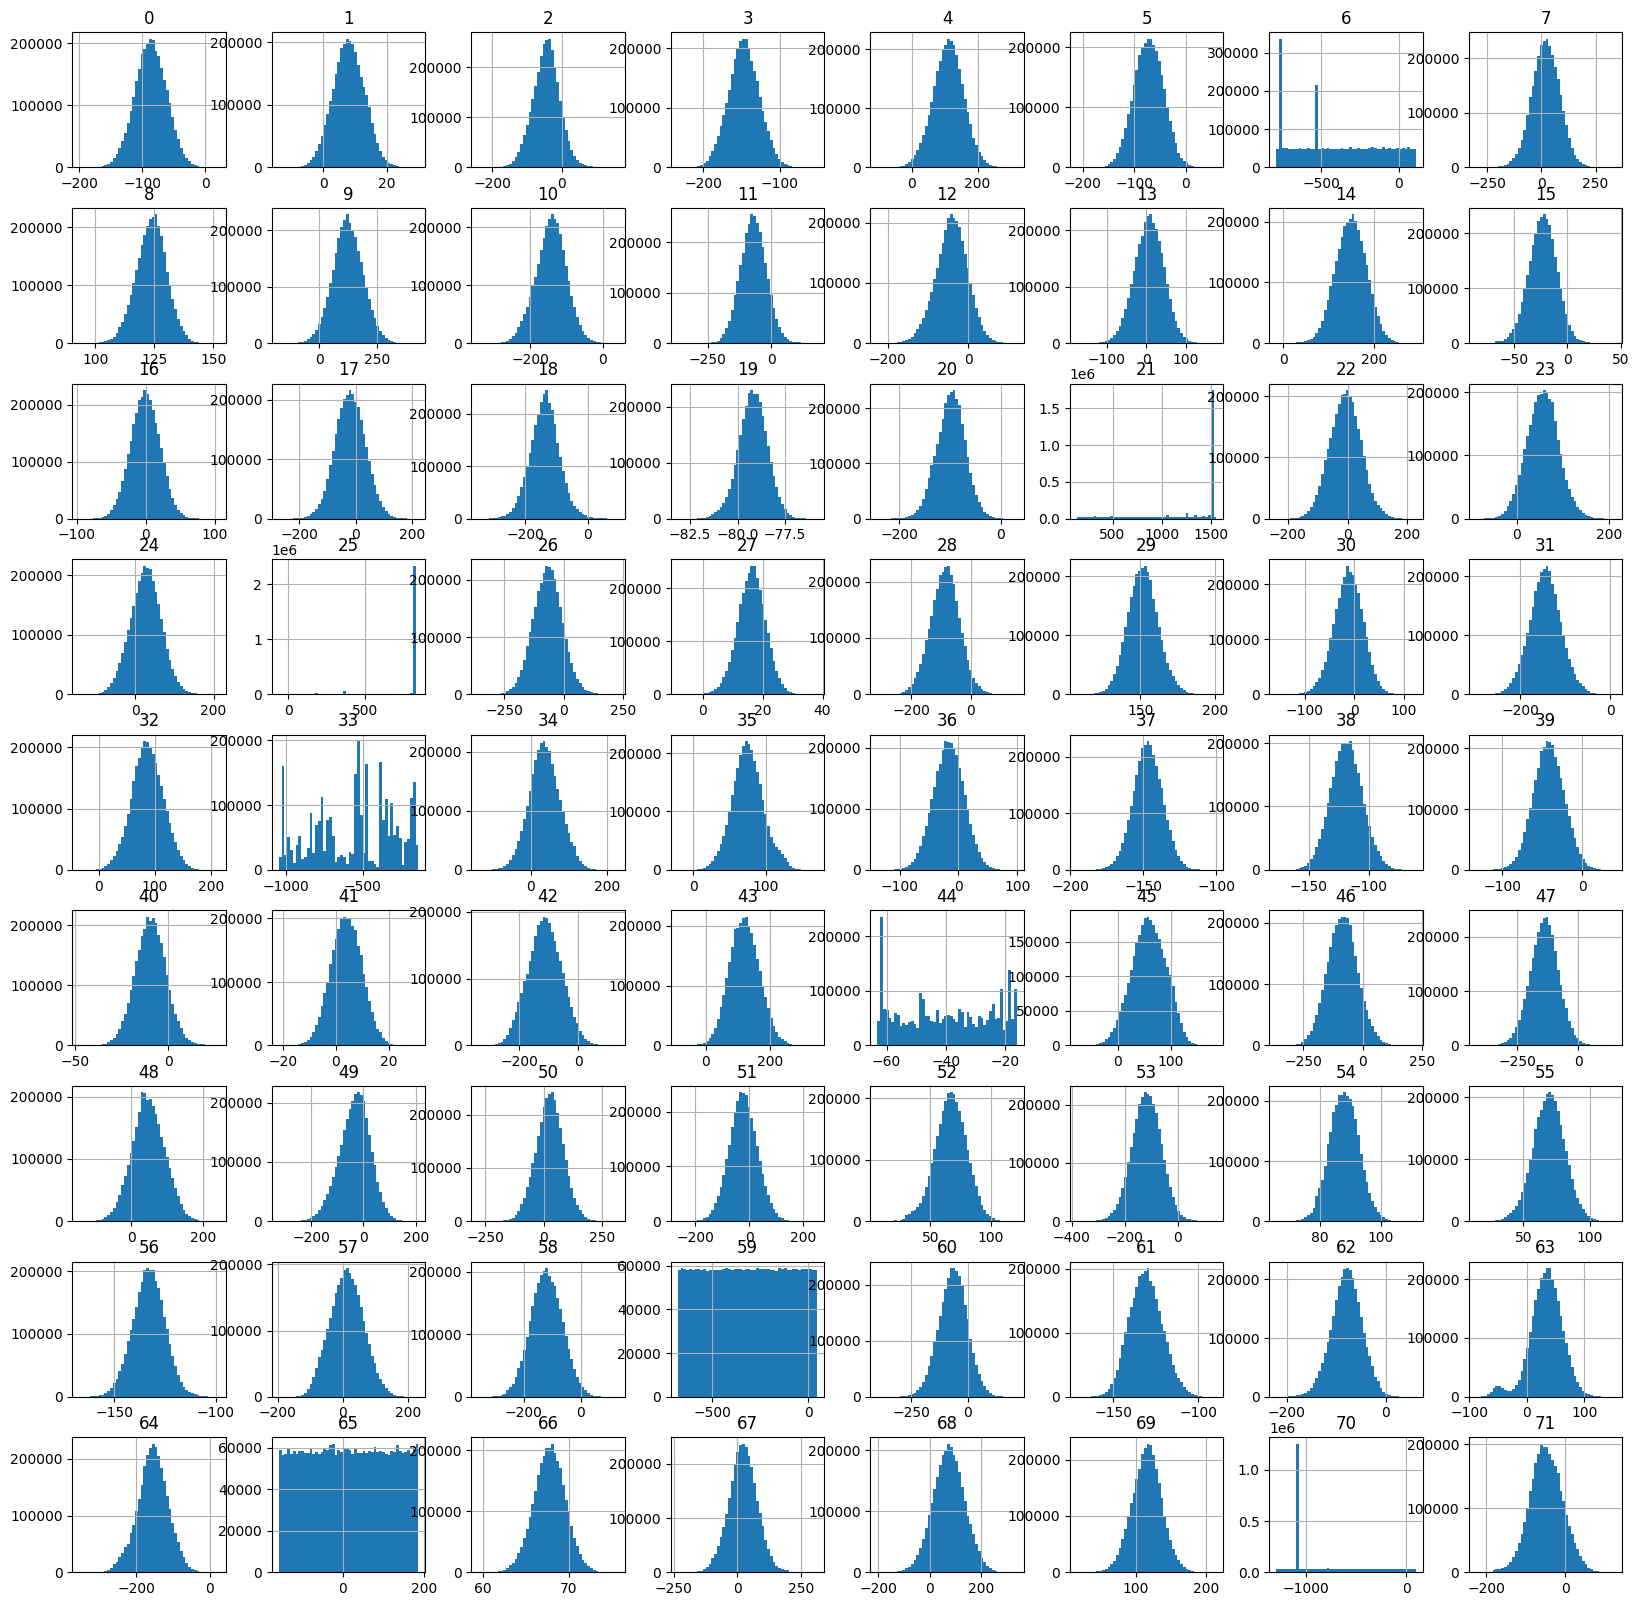

In [10]:
df_base.hist(bins=50, figsize=(20, 20))
None

Сохраним индексы параметров, который имеют распределение, отличное от нормального

In [11]:
abnormal_cols = ['6', '21', '25', '33', '44', '59', '65', '70']

# Поиск и оценка результатов

## Создадим словарь из названия товаров и их индексов

In [12]:
indexes = {k: v for k, v in enumerate(df_base.index.to_list())}

## Функция оценки

In [13]:
def accuracy5(predicts, answers, indexes=indexes):
    acc = 0
    for answer, predict in zip(answers.tolist(), predicts.tolist()):
        acc += int(answer in [indexes[r] for r in predict])

    return (acc * 100 / len(predicts))

## Функция поиска

In [14]:
def search(base_df, train_target_df, clusters=200, sample_count=50_000, answer_count=5, n_probe=1, metric=faiss.METRIC_L2):
    dimensions = base_df.shape[1]
    quantizer = faiss.IndexFlatL2(dimensions)
    idx_l2 = faiss.IndexIVFFlat(quantizer, dimensions, clusters, metric)
    idx_l2.nprobe = n_probe
    idx_l2.train(np.ascontiguousarray(base_df[:sample_count, :]).astype('float32'))
    idx_l2.add(np.ascontiguousarray(base_df).astype('float32'))
    answer, train_idx = idx_l2.search(np.ascontiguousarray(train_target_df).astype('float32'), answer_count)
    return (answer, train_idx)

## Поиск по сырым данным

In [15]:
%%time
ans, idx = search(df_base.values, df_train.values)
print('Accuracy@5 на сырых данных: {}\n'.format(accuracy5(idx, df_train_target)))

Accuracy@5 на сырых данных: 6.35

CPU times: user 3min 17s, sys: 841 ms, total: 3min 18s
Wall time: 13.7 s


### Вывод

Метрика на "сырых" данных крайне низкая, очевидно, что для решения задачи нам потребуется применить различные техники предобработки данных

## Поиск по масштабированным данным

Масштабируем данные различными способами

In [16]:
standard_scaler = StandardScaler().fit(df_base)
df_base_ss = standard_scaler.transform(df_base)
df_train_ss = standard_scaler.transform(df_train)
df_valid_ss = standard_scaler.transform(df_valid)

In [17]:
min_max_scaler = MinMaxScaler().fit(df_base)
df_base_mms = min_max_scaler.transform(df_base)
df_train_mms = min_max_scaler.transform(df_train)
df_valid_mms = min_max_scaler.transform(df_valid)

In [18]:
max_abs_scaler = MaxAbsScaler().fit(df_base)
df_base_mas = max_abs_scaler.transform(df_base)
df_train_mas = max_abs_scaler.transform(df_train)
df_valid_mas = max_abs_scaler.transform(df_valid)

In [19]:
robust_scaler = RobustScaler().fit(df_base)
df_base_rs = robust_scaler.transform(df_base)
df_train_rs = robust_scaler.transform(df_train)
df_valid_rs = robust_scaler.transform(df_valid)

Сравним разные способы масштабирования

In [20]:
%%time
ans, idx = search(df_base_ss, df_train_ss)
print('Accuracy@5 на масштабированных данных (StandardScaler): {}\n'.format(accuracy5(idx, df_train_target.values)))

Accuracy@5 на масштабированных данных (StandardScaler): 55.211

CPU times: user 3min 36s, sys: 434 ms, total: 3min 37s
Wall time: 14.8 s


In [21]:
%%time
ans, idx = search(df_base_mms, df_train_mms)
print('Accuracy@5 на масштабированных данных (MinMaxScaler): {}\n'.format(accuracy5(idx, df_train_target.values)))

Accuracy@5 на масштабированных данных (MinMaxScaler): 9.629

CPU times: user 3min 35s, sys: 524 ms, total: 3min 35s
Wall time: 14.6 s


In [22]:
%%time
ans, idx = search(df_base_mas, df_train_mas)
print('Accuracy@5 на масштабированных данных (MaxAbsScaler): {}\n'.format(accuracy5(idx, df_train_target.values)))

Accuracy@5 на масштабированных данных (MaxAbsScaler): 16.159

CPU times: user 3min 36s, sys: 468 ms, total: 3min 36s
Wall time: 14.7 s


In [23]:
%%time
ans, idx = search(df_base_rs, df_train_rs)
print('Accuracy@5 на масштабированных данных (RobustScaler): {}\n'.format(accuracy5(idx, df_train_target.values)))

Accuracy@5 на масштабированных данных (RobustScaler): 46.719

CPU times: user 3min 33s, sys: 573 ms, total: 3min 33s
Wall time: 14.7 s


### Вывод

Из всех способов масштабирования лучший результат показал StandardScaler, им и будем пользоваться в дальнейшем

## Отбросим данные, распределенные не-нормально

In [24]:
df_base_drop = df_base.drop(abnormal_cols, axis=1)
df_train_drop = df_train.drop(abnormal_cols, axis=1)
df_valid_drop = df_valid.drop(abnormal_cols, axis=1)

In [25]:
drop_scaler = StandardScaler().fit(df_base_drop)
df_base_drop_ss = drop_scaler.transform(df_base_drop)
df_train_drop_ss = drop_scaler.transform(df_train_drop)
df_valid_drop_ss = drop_scaler.transform(df_valid_drop)

In [26]:
%%time
ans, idx = search(df_base_drop_ss, df_train_drop_ss)
print('Accuracy@5 на "нормальных" масштабированных данных (StandardScaler): {}\n'.format(accuracy5(idx, df_train_target.values)))

Accuracy@5 на "нормальных" масштабированных данных (StandardScaler): 62.615

CPU times: user 3min 13s, sys: 449 ms, total: 3min 13s
Wall time: 13.2 s


### Вывод

Отбросив данные, имеющие распределение, отличное от нормального, мы добились улучшения результата целевой метрики

## Переберём параметр количества сэмплов

In [27]:
%%time
for sample_count in range(30_000, 150_001, 20_000):
    ans, idx = search(df_base_drop_ss, df_train_drop_ss, sample_count=sample_count)
    print('Accuracy@5 на "нормальных" масштабированных данных (StandardScaler), сэмплов {}: {}'.format(
        sample_count,
        accuracy5(idx, df_train_target.values)
    ))

Accuracy@5 на "нормальных" масштабированных данных (StandardScaler), сэмплов 30000: 62.469
Accuracy@5 на "нормальных" масштабированных данных (StandardScaler), сэмплов 50000: 62.615
Accuracy@5 на "нормальных" масштабированных данных (StandardScaler), сэмплов 70000: 62.812
Accuracy@5 на "нормальных" масштабированных данных (StandardScaler), сэмплов 90000: 62.704
Accuracy@5 на "нормальных" масштабированных данных (StandardScaler), сэмплов 110000: 62.606
Accuracy@5 на "нормальных" масштабированных данных (StandardScaler), сэмплов 130000: 62.611
Accuracy@5 на "нормальных" масштабированных данных (StandardScaler), сэмплов 150000: 62.628
CPU times: user 23min 18s, sys: 3.1 s, total: 23min 22s
Wall time: 1min 35s


### Вывод

Изменение количества сэмплов практически не влияет на метрику

## Переберём параметр количества центроидов

In [28]:
%%time
for clusters in range(10, 221, 30):
    ans, idx = search(df_base_drop_ss, df_train_drop_ss, clusters=clusters)
    print('Accuracy@5 на "нормальных" масштабированных данных (StandardScaler), центроидов {}: {}'.format(
        clusters,
        accuracy5(idx, df_train_target.values)
    ))

Accuracy@5 на "нормальных" масштабированных данных (StandardScaler), центроидов 10: 63.524
Accuracy@5 на "нормальных" масштабированных данных (StandardScaler), центроидов 40: 63.038
Accuracy@5 на "нормальных" масштабированных данных (StandardScaler), центроидов 70: 62.973
Accuracy@5 на "нормальных" масштабированных данных (StandardScaler), центроидов 100: 63.122
Accuracy@5 на "нормальных" масштабированных данных (StandardScaler), центроидов 130: 62.829
Accuracy@5 на "нормальных" масштабированных данных (StandardScaler), центроидов 160: 62.737
Accuracy@5 на "нормальных" масштабированных данных (StandardScaler), центроидов 190: 62.656
Accuracy@5 на "нормальных" масштабированных данных (StandardScaler), центроидов 220: 62.39
CPU times: user 1h 32min 47s, sys: 7.18 s, total: 1h 32min 54s
Wall time: 6min 6s


### Вывод

Уменьшение количества центроидов ожидаемо улучшает результат, но незначительно, зато увеличивает время работы. Поэтому надо найти баланс, возьмём в качестве числа центроидов 100.

## Переберём количество центроидов для поиска

Устроим перебор параметра `nprobe` у индекса, который отвечает за количество центроидов, возле которых будет произведён поиск

In [29]:
%%time
for n_probe in range(1, 8):
    ans, idx = search(df_base_drop_ss, df_train_drop_ss, clusters=100, n_probe=n_probe)
    print('Accuracy@5 на "нормальных" масштабированных данных (StandardScaler), центроидов 100, n_probe={}: {}'.format(
        n_probe,
        accuracy5(idx, df_train_target.values)
    ))

Accuracy@5 на "нормальных" масштабированных данных (StandardScaler), центроидов 100, n_probe=1: 63.122
Accuracy@5 на "нормальных" масштабированных данных (StandardScaler), центроидов 100, n_probe=2: 67.437
Accuracy@5 на "нормальных" масштабированных данных (StandardScaler), центроидов 100, n_probe=3: 68.753
Accuracy@5 на "нормальных" масштабированных данных (StandardScaler), центроидов 100, n_probe=4: 69.406
Accuracy@5 на "нормальных" масштабированных данных (StandardScaler), центроидов 100, n_probe=5: 69.774
Accuracy@5 на "нормальных" масштабированных данных (StandardScaler), центроидов 100, n_probe=6: 70.003
Accuracy@5 на "нормальных" масштабированных данных (StandardScaler), центроидов 100, n_probe=7: 70.183
CPU times: user 2h 51min 44s, sys: 15 s, total: 2h 51min 59s
Wall time: 11min 22s


### Вывод

Увеличение количества центроидов для поиска увеличивает целевую метрику, но чем выше значение - тем дольше поиск, поэтому есть смысл остановиться на последнем значении - 7, после него прирост незначительный, а затраты по времени существенные.

# Поиск рекомендаций в валидационной выборке и итоговая оценка

Посчитаем рекомендации для валидационной выборки, используя лучшие параметры, найденные нами на предыдущих шагах выполнения работы, и вычислим метрику accuracy@5, используя для проверки датафрейм с ответами

In [34]:
%%time
ans, idx = search(df_base_drop_ss, df_valid_drop_ss, clusters=100, n_probe=7)
print('Accuracy@5 на "нормальных" масштабированных данных (StandardScaler), центроидов 100, n_probe=5: {}'.format(
    accuracy5(idx, df_answer['expected'].values)
))

Accuracy@5 на "нормальных" масштабированных данных (StandardScaler), центроидов 100, n_probe=5: 70.018
CPU times: user 43min 44s, sys: 1.31 s, total: 43min 45s
Wall time: 2min 48s


# Вывод

С помощью предобработки данных, масштабирования и подбора параметров удалось добиться повышения метрики accuracy@5 с 6.35% (для сырых данных) до 70.183% на тренировочных данных. Метрика accuracy@5 на валидационной выборке составила 70.018%, что я считаю очень хорошим результатом, учитывая, что разбираться в библиотеке пришлось практически с нуля. Метрика сошлась на тренировочных и валидационных данных, следовательно модель обучена хорошо.